# Comparing Models

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [1]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic, get_response_replicate, create_config_dict_func, compare_request_configurations, generate_model_configs
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import files_to_df_func, files_to_df_core_func

import re


from dotenv import load_dotenv, find_dotenv
load_dotenv()
save_appendix = os.getenv("save_appendix")
save_figs = os.getenv("save_figs")

dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )


#NCSE

ncse_folder = 'data/transcription_returned_ocr'
ncse_articles_raw = os.path.join(ncse_folder, 'transcription_raw_ocr')
ncse_articles_transcribed = os.path.join(ncse_folder, 'transcription_files') 
ncse_articles_results = os.path.join(ncse_folder, 'corrected_folder')

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'article_level', 'raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')

ca_folder =  os.path.join(overproof_folder, 'CA')
ca_articles_raw = os.path.join(ca_folder, 'article_level', 'raw')
ca_articles_transcribed = os.path.join(ca_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
ca_articles_results = os.path.join(ca_folder, 'results')

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))


#for saving data to be used in the analysis
if not os.path.exists('data/analysis'):
    os.makedirs('data/analysis')


wer = load("wer")
cer = load("cer")


model_name_code = pd.Series(
    {'Llama 2 70B':'llama2-70b-4096',
 'Gemma 7B':'gemma-7b-it',
 'Claude 3 Opus':'claude-3-opus-20240229',
 'Claude 3 Haiku':'claude-3-haiku-20240307',
 'GPT-4':'gpt-4-turbo-preview',
 'GPT-3.5':'gpt-3.5-turbo',
 'Mixtral 8x7B':'mixtral-8x7b-32768',
 "Llama 3":'meta-llama-3-70b-instruct',
 "Llama 3 base":'meta/meta-llama-3-70b',
 'Overproof':'overproof'})


eval_metric = 'CER'

/home/jonno/clocrc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Evaluate system prompt tests

We evaluate the system prompts below to see if thre is any significant difference between the prompts


# Evaluating models on the test set

Having identified two different prompts and that the prompts appear to work better when places after the text we can now compare the different models


The below code creates the basic configuration dictionaries for each model and then fills in the with the two different prompt messages creating a single list of all basic prompt/model configurations. It then calls all the LLM's and saves the results.
This works in series so takes a while.

## Create API configurations

In [2]:
#Create the prompt/system message using the best performing from the previous section

full_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from an english newspaper in the 1800's. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

boros_basic  = "{content_html}"+f""" \n \n """ +"Correct the text"

boros_complex  ="{content_html}"+f""" \n \n """ + f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""

In [17]:
groq_alt_endpoint = {'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}

basic_model_configs = pd.DataFrame({
    'get_response_func': [get_response_openai, get_response_openai, get_response_openai, get_response_openai,
                           get_response_anthropic, get_response_anthropic, 
                          get_response_openai,# get_response_openai, 
                          get_response_openai, get_response_replicate,# get_response_replicate, 
                          get_response_replicate], 
    'engine': ['gpt-3.5-turbo', 'gpt-4-turbo-preview', 'gpt-4o', 'gpt-4o-mini',
               "claude-3-haiku-20240307", "claude-3-opus-20240229", 
               'mixtral-8x7b-32768',#'llama2-70b-4096', 
               'gemma-7b-it', 'meta/meta-llama-3-70b-instruct', 'meta/meta-llama-3-70b',
                # 'meta/llama-2-70b'
                 ],
    'rate_limit':[160e3, 80e3, 160e3, 160e3,
                  100e3, 40e3, 9e3, #15e3,
                   15e3, 100e3,# 100e3,
                     100e3],
    'additional_args': [
        {}, {}, {}, {}, 
        {},{},
        groq_alt_endpoint, 
        #groq_alt_endpoint, 
        groq_alt_endpoint,
        {}, {}#,{}
    ]
})

full_model_configs = generate_model_configs(basic_model_configs, full_prompt, 'full')
instruct_model_configs = generate_model_configs(basic_model_configs, instruct_prompt, 'instruct')

#I think on reflection I only need to compare boros complex on gpt-4 as this was the best performer in their paper
boros_configs_ncse = [
    (get_response_openai, 'gpt-4-turbo-preview', boros_complex, "boros_complex_"),
]

boros_list = [
    create_config_dict_func(
        get_response_func=config[0],
        rate_limiter=RateLimiter(80e3),
        engine=config[1],
        system_message_template="",
        prompt_template=config[2],
        additional_args={"response_name": config[3]}
    )
    for config in boros_configs_ncse
]

model_configs = full_model_configs + instruct_model_configs + boros_list



## Perform all API calls

The below section is what actually calls the API, the code points to the folders where the raw OCR is and provides a path to where the corrected text should be stored.

### NCSE

In [20]:
corrected_folder = ncse_articles_results
#
# This naming business needs to be cleaned up so the actual article ID is used. until then just have the following mess
#
# 

test_data_new = pd.read_csv(os.path.join(dev_data_folder,'transcription_raw_ocr.csv'))
test_data_new = test_data_new.loc[test_data_new ['file_name'].isin(files_to_df_func(ncse_articles_transcribed )['file_name'])] #subset to just the data I have transcribed

#This goes through the list of articles that have been transcribed, checks to see if there is a corrected version and if not generates it
compare_request_configurations(test_data_new, model_configs, folder_path=corrected_folder)

### Boros etal re-evaluation

The post-OCR correction worked so well that the Boros etal prompt is being re-evaluated

In [23]:
boros_complex  ="{content}"+f""" \n \n """ + f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""


boros_config = generate_model_configs(basic_model_configs.iloc[0:2, :], boros_complex, 'boros_complex')[1]

### Sydney Morning Herald

This section performs the correction test on dataset 2 of the Overproof collection. This is data from the Sydney Morning Herald. In addition it re-tests the Boros et al.

In [24]:
smh_data = files_to_df_core_func(smh_articles_raw )

smh_data['content'] = smh_data['content'].str.replace('\n', ' ')

smh_data['id'] = smh_data['file_name'] # this is needed as the processing log uses an id to keep track of what has been processed and what hasn't to allow for easy restarts

full_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from The Sydney Morning Herald 1842 -1950. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

full_model_configs_smh = generate_model_configs(basic_model_configs, full_prompt_smh, 'full')
instruct_model_configs_smh = generate_model_configs(basic_model_configs, instruct_prompt_smh, 'instruct')

#Boros et al prompt added in as the overall system works so well, it seems strange theirs didn't work, this is a quick check
smh_configs = full_model_configs_smh + instruct_model_configs_smh  + [boros_config ]

corrected_folder_smh = smh_articles_results

compare_request_configurations(smh_data, smh_configs, folder_path=corrected_folder_smh)

### Chronicalling America

This section performs the correction test on dataset 2 of the Overproof collection. This is data from the Chronicalling America Dataset. 

In [3]:
ca_data = files_to_df_core_func(ca_articles_raw )

ca_data['content'] = ca_data['content'].str.replace('\n', ' ')

ca_data['id'] = ca_data['file_name'] # this is needed as the processing log uses an id to keep track of what has been processed and what hasn't to allow for easy restarts

full_prompt_ca = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from American Newspapers 1870 -1922. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt_ca = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""


full_model_configs_ca = generate_model_configs(basic_model_configs, full_prompt_ca, 'full')
instruct_model_configs_ca = generate_model_configs(basic_model_configs, instruct_prompt_ca, 'instruct')

ca_configs = full_model_configs_ca + instruct_model_configs_ca  + [boros_config ]

corrected_folder_ca = ca_articles_results

compare_request_configurations(ca_data, ca_configs, folder_path=corrected_folder_ca)

NameError: name 'basic_model_configs' is not defined

## Evaluate the prompts across all models

On the smaller models, Full is worse than instruct on the larger models the reverse. Maybe this is related to ability to 'focus' or hold isntructions in memory?

In [4]:
##
## double check get_metric_error_reduction
##

corrected_folder = ncse_articles_results 

gt_folder = ncse_articles_transcribed 

raw_ocr = ncse_articles_raw

ncse_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

ncse_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')


ncse_error_reduction = get_metric_error_reduction(ncse_performance_eval, ncse_raw_ocr_eval )

ncse_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

,WER,CER,lev_dist
,50%,50%,50%
type,,,
instruct__meta-llama-3-70b,-102.41,-587.99,-592.88
full__meta-llama-3-70b,-102.68,-481.02,-468.17
full__llama2-70b-4096,56.83,-28.27,-27.33
instruct__llama2-70b-4096,53.24,-11.20,-12.44
full__gemma-7b-it,20.47,-2.34,-2.55
instruct__gemma-7b-it,20.35,0.15,0.12
full__mixtral-8x7b-32768,48.72,6.60,5.74
instruct__mixtral-8x7b-32768,48.48,7.01,6.69


In [71]:
print(ncse_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))
ncse_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER   CER lev_dist
          50%   50%      50%
type                        
raw_ocr  0.63  0.17    341.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
instruct__claude-3-opus-20240229,0.15,0.06,115.0
full__claude-3-opus-20240229,0.15,0.07,113.0
full__gpt-4o,0.18,0.09,115.0
boros_complex__gpt-4-turbo-preview,0.17,0.09,127.0
full__gpt-4-turbo-preview,0.17,0.09,114.0
instruct__gpt-4o,0.15,0.09,115.0
instruct__gpt-4-turbo-preview,0.17,0.10,126.0
instruct__gpt-4o-mini,0.23,0.12,153.0


In [72]:
corrected_folder = smh_articles_results 

gt_folder = smh_articles_transcribed 

raw_ocr = smh_articles_raw

smh_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

smh_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')

smh_error_reduction = get_metric_error_reduction(smh_performance_eval, smh_raw_ocr_eval )

smh_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

,WER,CER,lev_dist
,50%,50%,50%
type,,,
full__llama-2-70b,-89.25,-963.01,-914.86
instruct__llama-2-70b,-89.50,-958.60,-895.77
instruct__meta-llama-3-70b,-88.52,-867.47,-865.27
full__meta-llama-3-70b,-90.56,-864.63,-853.01
full__gemma-7b-it,3.26,-35.65,-35.34
instruct__mixtral-8x7b-32768,17.39,-19.11,-20.00
full__mixtral-8x7b-32768,18.00,-14.63,-15.24
instruct__gemma-7b-it,9.66,-12.93,-13.04


In [75]:
print(smh_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))

smh_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER   CER lev_dist
          50%   50%      50%
type                        
raw_ocr  0.51  0.08    131.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
boros_complex__gpt-4-turbo-preview,0.34,0.04,65.0
full__claude-3-haiku-20240307,0.37,0.04,73.0
full__claude-3-opus-20240229,0.34,0.04,69.0
instruct__gpt-4o-mini,0.35,0.04,75.0
full__gpt-3.5-turbo,0.35,0.04,87.0
instruct__gpt-4o,0.34,0.04,62.0
full__gpt-4o,0.34,0.04,62.0
full__gpt-4o-mini,0.35,0.04,76.0


In [73]:
corrected_folder = ca_articles_results 

gt_folder = ca_articles_transcribed 

raw_ocr = ca_articles_raw

ca_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

ca_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')

ca_error_reduction = get_metric_error_reduction(ca_performance_eval, ca_raw_ocr_eval )

ca_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))


,WER,CER,lev_dist
,50%,50%,50%
type,,,
full__llama-2-70b,-59.57,-784.90,-761.72
instruct__llama-2-70b,-61.06,-752.31,-741.10
full__meta-llama-3-70b,-71.75,-741.39,-739.31
instruct__meta-llama-3-70b,-63.14,-729.38,-725.21
instruct__gemma-7b-it,5.66,-41.00,-42.38
full__gemma-7b-it,3.04,-38.01,-38.15
instruct__mixtral-8x7b-32768,13.72,-22.07,-22.36
full__mixtral-8x7b-32768,15.72,-16.30,-14.86


In [77]:
print(ca_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))

ca_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER  CER lev_dist
          50%  50%      50%
type                       
raw_ocr  0.62  0.1    198.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
boros_complex__gpt-4-turbo-preview,0.45,0.05,107.0
full__claude-3-opus-20240229,0.43,0.05,117.0
instruct__gpt-4o,0.44,0.05,101.5
full__gpt-4o,0.46,0.05,102.5
instruct__gpt-3.5-turbo,0.45,0.05,100.5
instruct__claude-3-opus-20240229,0.44,0.05,119.0
instruct__gpt-4o-mini,0.46,0.06,114.0
full__gpt-3.5-turbo,0.46,0.06,108.0


In [75]:
ncse_median = ncse_error_reduction.groupby('type')[eval_metric].median().round(1)
smh_median = smh_error_reduction.groupby('type')[eval_metric].median().round(1)
ca_median = ca_error_reduction.groupby('type')[eval_metric].median().round(1)

# Combine the results into a new dataframe
result_df = pd.DataFrame({
    'NCSE': ncse_median,
    'SMH': smh_median,
    'CA': ca_median
})

# Reset the index to make 'type' a regular column
result_df = result_df.reset_index()

result_df = result_df.loc[~result_df['type'].isin(['boros_basic__gpt-4-turbo-preview',  'claude_temp_claude-3-opus-20240229'])]

result_df['model'] = result_df['type'].str.split('_').str[-1]
result_df['prompt'] = result_df['type'].str.split('_').str[0]

result_df = result_df.sort_values('NCSE').merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model').rename(columns={'index': 'Model'})

result_df['Model'] = np.where(result_df['prompt']=='boros', result_df['Model'] + " Boros", result_df['Model'])

#result_df = result_df.loc[~(result_df['Model'].str.contains('Llama 2'))]

result_df[['Model', 'prompt', 'NCSE', 'SMH', 'CA']].sort_values(['NCSE'])

,Model,prompt,NCSE,SMH,CA
0,Llama 2 70B,full,-28.3,5.8,-4.9
1,Llama 2 70B,instruct,-11.2,6.5,-6.5
2,Gemma 7B,full,-2.3,-35.7,-38.0
3,Gemma 7B,instruct,0.1,-12.9,-41.0
4,Mixtral 8x7B,full,6.6,-14.6,-16.3
5,Mixtral 8x7B,instruct,7.0,-19.1,-22.1
6,Claude 3 Haiku,full,14.0,38.4,26.0
7,Llama 3,instruct,16.1,17.9,14.2
8,Llama 3,full,19.1,12.9,-9.4
9,Claude 3 Haiku,instruct,27.8,35.7,34.7


In [46]:
def render_latex_with_formatting(df, caption, label):

    df = df.copy()
    # Format the 'Total' row by appending \textbf{} to each element
    #df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
    
    # Convert DataFrame to LaTeX
    latex_table = df.to_latex(
        index=False,
        float_format="%.2f" ,
        escape=False,  # Important to render LaTeX commands within the table properly
        column_format='p{5cm}cccc',  # One left-aligned column followed by four centered columns
        bold_rows=True,  # Bold the headers
        caption=caption,
        label=label
    )
    return latex_table


In [47]:
results_tab = result_df.loc[(result_df['prompt']!='instruct') & ~(result_df['Model'].str.contains('Llama 2')), ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model'])

results_tab = render_latex_with_formatting(results_tab,   
                            'Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.',
                            'tab:results'  )

print(results_tab)

\begin{table}
\caption{Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.}
\label{tab:results}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & NCSE & SMH & CA \\
\midrule
Claude 3 Haiku & 14.00 & 38.40 & 26.00 \\
Claude 3 Opus & 64.10 & 51.00 & 48.20 \\
GPT-3.5 & 37.70 & 39.20 & 44.20 \\
GPT-4 & 60.40 & 42.10 & 38.20 \\
GPT-4 Boros & 61.70 & 48.40 & 45.60 \\
Gemma 7B & -2.30 & -35.70 & -38.00 \\
Llama 3 & 19.10 & 12.90 & -9.40 \\
Mixtral 8x7B & 6.60 & -14.60 & -16.30 \\
Overproof & NaN & 28.40 & 34.60 \\
\bottomrule
\end{tabular}
\end{table}



## Two metric table

In [81]:
import pandas as pd
import numpy as np
def create_combined_metric_table(error_reduction_df, performance_eval_df, model_name_code, agg_method='median'):
    """
    Creates a combined DataFrame with error reduction and performance evaluation metrics.
    
    Parameters:
    - error_reduction_df: DataFrame with error reduction data for all datasets
    - performance_eval_df: DataFrame with performance evaluation data for all datasets
    - model_name_code: DataFrame with model names and codes for merging
    - agg_method: str, either 'median' or 'mean' for aggregation method
    
    Returns:
    - A formatted DataFrame with combined metrics
    """
    datasets = error_reduction_df['dataset'].unique()
    
    def process_df(df, metric_name, agg_method='median'):
        df = df.copy()
        df['prompt'] = df['type'].str.split('_').str[0]
        df['model'] = df['type'].str.split('_').str[-1]
        
        if agg_method == 'median':
            return df.groupby(['type', 'prompt', 'model', 'dataset'])[metric_name].median().reset_index()
        elif agg_method == 'mean':
            return df.groupby(['type', 'prompt', 'model', 'dataset'])[metric_name].mean().reset_index()
        else:
            raise ValueError("agg_method must be either 'median' or 'mean'")
    
    # Process error reduction DataFrame
    erp_df = process_df(error_reduction_df, 'erp', agg_method)
    
    # Process performance evaluation DataFrame
    cer_df = process_df(performance_eval_df, 'cer', agg_method)
    
    # Rest of the function remains the same
    combined_df = erp_df.merge(cer_df, on=['type', 'prompt', 'model', 'dataset'], suffixes=('_erp', '_cer'))
    
    combined_df = combined_df.pivot(index=['type', 'prompt', 'model'], columns='dataset', 
                                    values=['erp', 'cer']).round(2)
    
    combined_df.columns = [f'{metric.upper()}_{dataset}' for metric, dataset in combined_df.columns]
    
    combined_df = combined_df.reset_index()
    
    combined_df = combined_df.merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model')
    combined_df = combined_df.rename(columns={'index': 'Model'})
    
    combined_df['Model'] = np.where(combined_df['prompt'] == 'boros', combined_df['Model'] + " Boros", combined_df['Model'])
    
    combined_df = combined_df.loc[(combined_df['prompt']!='instruct') & ~combined_df['Model'].str.contains('Llama 2')]
    
    combined_df = combined_df.set_index('Model').drop(columns=['type', 'prompt', 'model'])
    
    column_order = []
    for dataset in datasets:
        column_order.extend([f'ERP_{dataset}', f'CER_{dataset}'])
    combined_df = combined_df[column_order]
    
    combined_df.columns = pd.MultiIndex.from_tuples([(col.split('_')[1], col.split('_')[0]) for col in combined_df.columns])
    
    combined_df = combined_df.sort_index(axis=1, level=0)
    
    return combined_df.reset_index()



error_reduction_df = pd.concat([
    ncse_error_reduction.assign(dataset='NCSE'),
    smh_error_reduction.assign(dataset='SMH'),
    ca_error_reduction.assign(dataset='CA')
], ignore_index=True)

# Create performance_eval_df
performance_eval_df = pd.concat([
    ncse_performance_eval.assign(dataset='NCSE'),
    smh_performance_eval.assign(dataset='SMH'),
    ca_performance_eval.assign(dataset='CA')
], ignore_index=True)

# Rename 'wer' column to 'erp' in error_reduction_df if necessary

error_reduction_df = error_reduction_df.rename(columns={'CER': 'erp'})
performance_eval_df = performance_eval_df.rename(columns={'CER': 'cer'})

Original_error = {'NCSE':{'CER':0.17, 'ERP':0},
 'SMH':{'CER':0.08, 'ERP':0},
 'CA':{'CER':0.1, "ERP":0}}


result_df = create_combined_metric_table(error_reduction_df, performance_eval_df, model_name_code, 'mean').sort_values(['Model'])

result_df = result_df[['Model','NCSE', 'SMH', 'CA']]

In [80]:
result_df

Model  NCSE          SMH           CA       
                    CER    ERP   CER    ERP   CER    ERP
1  Claude 3 Haiku  0.44  14.04  0.04  38.38  0.07  26.01
2   Claude 3 Opus  0.07  64.09  0.04  51.03  0.05  48.23
4         GPT-3.5  0.23  37.65  0.04  39.18  0.06  44.22
5           GPT-4  0.09  60.42  0.05  42.08  0.06  38.18
0     GPT-4 Boros  0.09  61.67  0.04  48.44  0.05  45.55
3        Gemma 7B  0.52  -2.34  0.17 -35.65  0.15 -38.01
6         Llama 3  0.40  19.12  0.07  12.90  0.11  -9.42
7    Mixtral 8x7B  0.36   6.60  0.10 -14.63  0.12 -16.30
8       Overproof   NaN    NaN  0.05  28.38  0.07  34.59

In [82]:
result_df

Model  NCSE           SMH            CA        
                    CER     ERP   CER     ERP   CER     ERP
1  Claude 3 Haiku  0.40 -237.41  0.11  -40.65  0.18  -92.14
2   Claude 3 Opus  0.27  -28.51  0.05   45.92  0.06   43.51
4         GPT-3.5  0.27  -42.03  0.09   -0.52  0.11  -18.29
5           GPT-4  0.17   58.03  0.06   32.65  0.07   29.70
0     GPT-4 Boros  0.17   60.32  0.05   44.01  0.06   44.23
3        Gemma 7B  0.46 -241.18  0.27 -227.08  0.29 -209.20
6         Llama 3  0.36 -180.80  0.18 -111.94  0.20 -108.12
7    Mixtral 8x7B  0.37 -113.22  0.17  -58.17  0.17  -60.65
8       Overproof   NaN     NaN  0.07   27.28  0.07   34.11

In [123]:
# Generate the LaTeX code for the DataFrame including the index
combined_df = result_df
latex_code = combined_df.to_latex(index=False, 
                                  float_format="%.2f",
                                  caption='Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.',
                                  label='tab:results')

# Modify the LaTeX code to center column titles and ensure index is included
# Replace '\begin{tabular}{' with '\begin{tabular}{' to center the columns
latex_code = latex_code.replace(r'\begin{tabular}{', r'\begin{tabular}{c')  # Add column alignment for centering
latex_code = latex_code.replace(r'c', r'c', 1)  # Ensure the first 'c' aligns with the first column header

# Print the modified LaTeX code
print(latex_code)


\begin{table}
\caption{Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.}
\label{tab:results}
\begin{tabular}{clrrrrrr}
\toprule
Model & \multicolumn{2}{r}{NCSE} & \multicolumn{2}{r}{SMH} & \multicolumn{2}{r}{CA} \\
 & CER & ERP & CER & ERP & CER & ERP \\
\midrule
Claude 3 Haiku & 0.44 & 14.04 & 0.04 & 38.38 & 0.07 & 26.01 \\
Claude 3 Opus & 0.07 & 64.09 & 0.04 & 51.03 & 0.05 & 48.23 \\
GPT-3.5 & 0.23 & 37.65 & 0.04 & 39.18 & 0.06 & 44.22 \\
GPT-4 & 0.09 & 60.42 & 0.05 & 42.08 & 0.06 & 38.18 \\
GPT-4 Boros & 0.09 & 61.67 & 0.04 & 48.44 & 0.05 & 45.55 \\
Gemma 7B & 0.52 & -2.34 & 0.17 & -35.65 & 0.15 & -38.01 \\
Llama 3 & 0.40 & 19.12 & 0.07 & 12.90 & 0.11 & -9.42 \\
Mixtral 8x7B & 0.36 & 6.60 & 0.10 & -14.63 & 0.12 & -16.30 \\
Overproof & NaN & NaN & 0.05 & 28.38 & 0.07 & 34.59 \\
\bottom

In [48]:
results_tab = render_latex_with_formatting(result_df.loc[result_df['prompt']=='instruct', ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model']), 
                             'Model performance across the datasets measured in Error Reduction Percentage: higher numbers indicate better performance, negative nummbers indicate OCR quality worse than baseline. There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.',
                             'tab:results')

print(results_tab)

\begin{table}
\caption{Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.}
\label{tab:results}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & NCSE & SMH & CA \\
\midrule
Claude 3 Haiku & 27.80 & 35.70 & 34.70 \\
Claude 3 Opus & 62.70 & 45.50 & 47.00 \\
GPT-3.5 & 39.40 & 42.90 & 44.10 \\
GPT-4 & 59.80 & 41.80 & 37.60 \\
Gemma 7B & 0.10 & -12.90 & -41.00 \\
Llama 2 70B & -11.20 & 6.50 & -6.50 \\
Llama 3 & 16.10 & 17.90 & 14.20 \\
Mixtral 8x7B & 7.00 & -19.10 & -22.10 \\
\bottomrule
\end{tabular}
\end{table}



In [84]:
result_df.loc[result_df['prompt']=='instruct', ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model'])

,Model,NCSE,SMH,CA
9,Claude 3 Haiku,27.8,35.7,34.7
15,Claude 3 Opus,62.7,45.5,47.0
11,GPT-3.5,39.4,42.9,44.1
12,GPT-4,59.8,41.8,37.6
3,Gemma 7B,0.1,-12.9,-41.0
1,Llama 2 70B,-11.2,6.5,-6.5
7,Llama 3,16.1,17.9,14.2
5,Mixtral 8x7B,7.0,-19.1,-22.1


In [60]:
df_melted = result_df.melt(id_vars=['model', 'prompt'], value_vars=['NCSE', 'SMH', 'CA'], 
                    var_name='Dataset', value_name='Value')

df_full = result_df[result_df['prompt'] == 'full']
df_instruct = result_df[result_df['prompt'] == 'instruct']

# Melt the filtered DataFrames
df_full_melted = df_full.melt(id_vars=['model'], value_vars=['NCSE', 'SMH', 'CA'], var_name='Dataset', value_name='Value_Full')
df_instruct_melted = df_instruct.melt(id_vars=['model'], value_vars=['NCSE', 'SMH', 'CA'], var_name='Dataset', value_name='Value_Instruct')

df_merged = pd.merge(df_full_melted, df_instruct_melted, on=['model', 'Dataset'])

# Calculate the difference
df_merged['Difference'] = df_merged['Value_Full'] - df_merged['Value_Instruct']

df_merged = df_merged.loc[~(df_merged['model'].str.contains('llama2')),:].merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model').rename(columns={'index': 'Model'})


In [79]:
diff_df = df_merged.loc[:, ['Model', 'Dataset' ,'Value_Full', 'Value_Instruct', 'Difference']].sort_values('Model')

print(render_latex_with_formatting(diff_df, caption = 'The difference between the two prompts across all models and datasets', label= 'tab:prompt_diff'))

\begin{table}
\caption{The differnce between the two prompts across all models and datasets}
\label{tab:prompt_diff}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & Dataset & Value_Full & Value_Instruct & Difference \\
\midrule
Claude 3 Haiku & NCSE & 14.00 & 27.80 & -13.80 \\
Claude 3 Haiku & CA & 26.00 & 34.70 & -8.70 \\
Claude 3 Haiku & SMH & 38.40 & 35.70 & 2.70 \\
Claude 3 Opus & CA & 48.20 & 47.00 & 1.20 \\
Claude 3 Opus & NCSE & 64.10 & 62.70 & 1.40 \\
Claude 3 Opus & SMH & 51.00 & 45.50 & 5.50 \\
GPT-3.5 & CA & 44.20 & 44.10 & 0.10 \\
GPT-3.5 & NCSE & 37.70 & 39.40 & -1.70 \\
GPT-3.5 & SMH & 39.20 & 42.90 & -3.70 \\
GPT-4 & NCSE & 60.40 & 59.80 & 0.60 \\
GPT-4 & CA & 38.20 & 37.60 & 0.60 \\
GPT-4 & SMH & 42.10 & 41.80 & 0.30 \\
Gemma 7B & CA & -38.00 & -41.00 & 3.00 \\
Gemma 7B & NCSE & -2.30 & 0.10 & -2.40 \\
Gemma 7B & SMH & -35.70 & -12.90 & -22.80 \\
Llama 3 & NCSE & 19.10 & 16.10 & 3.00 \\
Llama 3 & CA & -9.40 & 14.20 & -23.60 \\
Llama 3 & SMH & 12.90 & 17.90 & -5.00 \\
Mixtr

In [82]:
diff_df.sort_values('Value_Full')

,Model,Dataset,Value_Full,Value_Instruct,Difference
2,Claude 3 Haiku,NCSE,14.0,27.8,-13.8
16,Claude 3 Haiku,CA,26.0,34.7,-8.7
9,Claude 3 Haiku,SMH,38.4,35.7,2.7
20,Claude 3 Opus,CA,48.2,47.0,1.2
6,Claude 3 Opus,NCSE,64.1,62.7,1.4
13,Claude 3 Opus,SMH,51.0,45.5,5.5
18,GPT-3.5,CA,44.2,44.1,0.1
4,GPT-3.5,NCSE,37.7,39.4,-1.7
11,GPT-3.5,SMH,39.2,42.9,-3.7
5,GPT-4,NCSE,60.4,59.8,0.6


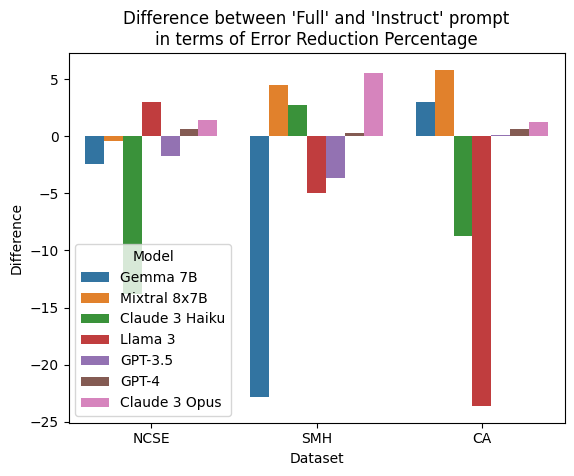

In [85]:
sns.barplot(data = df_merged, x = 'Dataset', y = 'Difference', hue = 'Model')
plt.title("Difference between 'Full' and 'Instruct' prompt\nin terms of Error Reduction Percentage")

plt.savefig(os.path.join(save_appendix,"prompt_comparison.pdf"))

# Sydney Morning Herald Dataset 1


Explore SMH with gpt4 only data

In [3]:

gpt4_only_configs = pd.DataFrame({
    'get_response_func': [get_response_openai], 
    'engine': ['gpt-4-turbo-preview'
                 ],
    'rate_limit':[300e3],
    'additional_args': [
        {}
    ]
})


smh1_articles_raw =  os.path.join(smh_folder, 'dataset1_article_level', 'raw')
corrected_folder_smh1 = os.path.join(smh_folder, 'results_dataset1')

smh_data1 = files_to_df_core_func(smh1_articles_raw )

smh_data1['content'] = smh_data1['content'].str.replace('\n', ' ')

smh_data1['id'] = smh_data1['file_name'] # this is needed as the processing log uses an id to keep track of what has been processed and what hasn't to allow for easy restarts

full_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from The Sydney Morning Herald 1842 -1950. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""


full_model_configs_smh1 = generate_model_configs(gpt4_only_configs, full_prompt_smh, 'full')

compare_request_configurations(smh_data1, full_model_configs_smh1, folder_path=corrected_folder_smh1)

In [5]:
corrected_folder_smh1

'data/overproof/SMH/results_dataset1'

In [23]:
gt_folder =   os.path.join(smh_folder, 'dataset1_article_level', 'corrected')

raw_ocr = smh_articles_raw


smh1_performance_eval =  evaluate_correction_performance_folders(corrected_folder_smh1, gt_folder, wer, cer)

smh1_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')

smh1_error_reduction = get_metric_error_reduction(smh1_performance_eval, smh_raw_ocr_eval )

smh1_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

ValueError: No objects to concatenate

In [28]:
from evaluation_funcs import load_txt_files_to_df, calculate_metrics

dev_data_raw_df = load_txt_files_to_df(os.path.join(corrected_folder_smh1, 
                                                    "full__gpt-4-turbo-preview")).merge(load_txt_files_to_df(gt_folder), on = 'file_name', suffixes=['_results', '_corrected'])



In [27]:
dev_data_raw_df

,content_html_results,file_name,content_html_corrected
0,THE MOVEMENT BY THE STRATHFIELD COUNCIL\n\nThe...,14038989_year_1896_type_Article_title_The_Sydn...,THE MOVEMENT BY THE STRATHFIELD\nCOUNCIL.\nThe...
1,The greatest difficulty is met with in obtaini...,14037364_year_1896_type_Article_title_The_Sydn...,NAMES OF THE MISSING.\nThe greatest difficulty...
2,BANKSTOWN. The fortnightly meeting of this cou...,14070806_year_1896_type_Article_title_The_Sydn...,BANKSTOWN.\nThe fortnightly meeting of this co...
3,"The Hannah Nicholson, though old, is well pres...",14058158_year_1896_type_Article_title_The_Sydn...,"THE HANNAH NICHOLSON IN DISTRESS.\nThe barque,..."
4,ARRANGEMENTS FOR THE FUNERAL. SERVICE TO BE HE...,14047181_year_1896_type_Article_title_The_Sydn...,ARRANGEMENTS FOR THE FUNERAL.\nSERVICE TO BE H...
...,...,...,...
542,PASTORAL INTELLIGENCE. (From our CORRESPONDENT...,14067427_year_1896_type_Article_title_The_Sydn...,PASTORAL INTELLIGENCE.\n(FROM OUR CORRESPONDEN...
543,AQUATICS. The death of Mr. L. M. Dietrich on T...,14060983_year_1896_type_Article_title_The_Sydn...,AQUATICS.\nTHE LATE MR. E. M. DIETRICH.\nThe d...
544,"BREACH OF PROMISE CASE. MELBOURNE, Tuesday. A ...",14064770_year_1896_type_Article_title_The_Sydn...,"BREACH OF PROMISE CASE.\nMELBOURNE, Tuesday.\n..."
545,WHAT MR. BUSSELL SAYS. SOME PARTICULARS OF THE...,14055213_year_1896_type_Article_title_The_Sydn...,WHAT MR. RUSSELL SAYS.\nSOME PARTICULARS OF TH...


In [41]:
import jellyfish

def calculate_metrics(file_name, raw_data_string, contents, wer, cer):
    wer_score = wer.compute(predictions=[raw_data_string], references=[contents])
    cer_score = cer.compute(predictions=[raw_data_string], references=[contents])
    leven_score = jellyfish.levenshtein_distance(raw_data_string, contents)
    
    # Here we prepare for vectorized computation
    #leven_distances = np.array([leven_score])
    #lengths = np.array([max(len(raw_data_string), len(contents))])
    
    #This is not very useful as I can use the error rate reduction
    #lev_sim = vectorized_levenshtein_similarity(leven_distances, lengths)[0]  # Get the first element since we're dealing with single values

    results_df = {
        'File Name': file_name,
        'WER': wer_score,
        'CER': cer_score,
        'lev_dist': leven_score
    }

    return results_df

In [40]:
metrics_df = dev_data_raw_df.apply(lambda row: calculate_metrics(row['file_name'], row['content_html_results'], row['content_html_corrected'], wer, cer), axis=1, result_type='expand')

# If you want to combine the original DataFrame with the new metrics
combined_df = pd.concat([dev_data_raw_df, metrics_df], axis=1)

In [43]:
combined_df.describe()

,WER,CER,lev_dist
count,547.000000,547.000000,547.000000
mean,0.370350,0.073910,140.804388
std,0.095112,0.055847,169.815533
min,0.233227,0.022565,18.000000
25%,0.307427,0.043045,60.000000
50%,0.341346,0.057927,96.000000
75%,0.394446,0.083303,165.000000
max,0.747368,0.546934,2550.000000


In [23]:
ncse_correct_compare= ncse_performance_eval.loc[ncse_performance_eval['type']=='full__claude-3-opus-20240229'].merge(ncse_raw_ocr_eval, on = 'File Name', suffixes=[' Corrected', " OCR"])
ncse_correct_compare['CER_diff'] = ncse_correct_compare['CER OCR'] - ncse_correct_compare['CER Corrected']

In [61]:
ncse_correct_compare.loc[ncse_correct_compare['CER OCR'].between(0.4, 0.5)]

,File Name,WER Corrected,CER Corrected,lev_dist Corrected,type Corrected,WER OCR,CER OCR,lev_dist OCR,type OCR,CER_diff
5,slug_ad01216_periodical_t_issue_ttw_21121867_p...,0.393443,0.265252,102,full__claude-3-opus-20240229,1.245902,0.490716,187,raw_ocr,0.225464
15,slug_ar00506_periodical_t_issue_ttw_16051868_p...,0.393617,0.249144,305,full__claude-3-opus-20240229,1.095745,0.452055,538,raw_ocr,0.202911
47,slug_ar00801_periodical_pc_issue_tec_01051889_...,0.152542,0.096317,73,full__claude-3-opus-20240229,1.279661,0.481586,343,raw_ocr,0.385269
59,slug_ad31203_periodical_pc_issue_tec_06121883_...,0.353659,0.267961,147,full__claude-3-opus-20240229,1.158537,0.464078,244,raw_ocr,0.196117
81,slug_ar00500_periodical_ewj_issue_ewj_01081858...,0.466797,0.390486,1189,full__claude-3-opus-20240229,0.787109,0.497192,1510,raw_ocr,0.106706


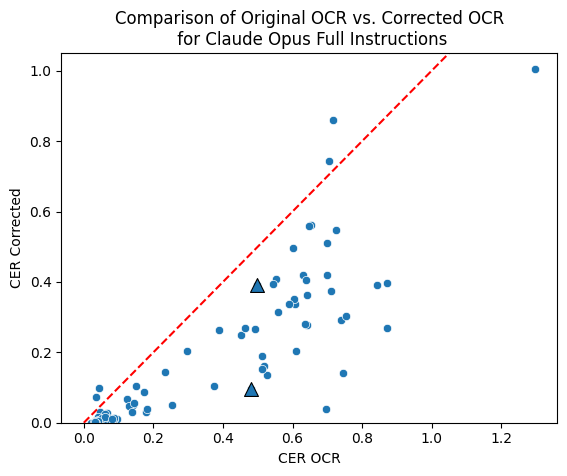

In [68]:

# Sample DataFrame creation (you should have this already)
# ncse_correct_compare = pd.read_csv('your_data.csv')  # Example of loading data

# Define the specific file names
file_names_to_highlight = [
    'slug_ar00500_periodical_ewj_issue_ewj_01081858_page_number_5.txt',
    'slug_ar00801_periodical_pc_issue_tec_01051889_page_number_8.txt'
]

# Filter the DataFrame for these specific file names
highlight_df = ncse_correct_compare[ncse_correct_compare['File Name'].isin(file_names_to_highlight)]

# Create the scatter plot with Seaborn
ax = sns.scatterplot(data=ncse_correct_compare, x='CER OCR', y='CER Corrected')

# Get the default color used by Seaborn for scatter plots
default_color = sns.color_palette()[0]

# Set the y-axis limit
plt.ylim([0, 1.05])

# Add the line x = y
plt.plot([0, 1.05], [0, 1.05], color='red', linestyle='--')

# Plot the specific points with triangles and black outline using the default color
sns.scatterplot(data=highlight_df, x='CER OCR', y='CER Corrected', 
                marker='^',  # Triangle marker
                edgecolor='black',  # Black outline
                color=default_color,  # Match the default scatter plot color
                s=100,  # Size of the markers
              #  label='Highlighted Examples', 
                ax=ax)  # Ensure it's on the same axes

# Optionally, add labels and title
plt.xlabel('CER OCR')
plt.ylabel('CER Corrected')
plt.title('Comparison of Original OCR vs. Corrected OCR\n for Claude Opus Full Instructions')

# Save the figure
plt.savefig(os.path.join(save_figs, "cer_relationship.pdf"))

# Show the plot
plt.show()

In [69]:
import re
from string import Template

def escape_latex(text):
    """Escape special LaTeX characters."""
    special_chars = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\textasciicircum{}',
        '\\': r'\textbackslash{}',
    }
    return ''.join(special_chars.get(c, c) for c in text)

gt_15091890 = "The Leadenhall Press will issue Mr. Jerome K. Jerome's new book, 'Told after Supper.' The publishers thought it necessary to bring out a far-thing booklet, in order to secure the copyright."
raw_ocr_15091890 = """Leadenhall ^^ ^ K ^ -J ^ b ^ r « E-fc «« I I Press 1 _ # * A J ^ . « M ^« will -W »»» I I issue < K »•» « M H ^ % Mr !>/¦ «« . Jerome I ^ % *»^ "V *^»^ rf\'V T K . Jerome publis \' h ers new have book though , * Told t it after necessary Supper to . \'the bring copyri out a ght far . thing booklet , in order to secure*"""
clocrc_opus_full_15091890 = "The Leadenhall Press will issue Mr. Jerome K. Jerome's new book, 'Told after Supper.' The publishers thought it necessary to bring out a far-thing booklet, in order to secure the copyright."


gt_tec_01051889 = """‘The Plague and the Printing Press: being a Bibliographical Record of the Literature relative to the Plague, printed in England since the Year 1480,’ with introduction and numerous notes, by Henry R. Plomer, is the attractive title of a book which Mr. Elliot Stock is about to publish by subscription.
"""
raw_ocr_tec_01051889 = """* The Plague and the Printing Press : being a Bibliographical Record of theLiterature relative to the Plague , printed in England since attractive numerous the Year notes title , 1480 of by a Henry , ' book with R which introduction . Plomer Mr . , is Elliot and theStock is about to publish by subscription ."""
clocrc_opus_01051889 = """The Plague and the Printing Press: being a Bibliographical Record of the Literature relative to the Plague, printed in England since the Year 1480, by Henry R. Plomer, with introduction and numerous attractive title notes, is a book which Mr. Elliot Stock is about to publish by subscription."""

# Your text strings (gt_15091890, clocrc_opus_full_15091890, raw_ocr_15091890)

# Generate table content
# Generate table content
table_content = f"""\\begin{{tabularx}}{{\\textwidth}}{{>{{\\raggedright\\arraybackslash}}X>{{\\raggedright\\arraybackslash}}X>{{\\raggedright\\arraybackslash}}X}}
\\toprule
\\textbf{{Ground Truth}}  & \\textbf{{Original OCR}}  & \\textbf{{Corrected}}\\\\
\\midrule
{escape_latex(gt_tec_01051889)} & 
\\texttt{{{escape_latex(raw_ocr_tec_01051889)}}} & 
{escape_latex(clocrc_opus_01051889)}  \\\\
\\bottomrule
\\end{{tabularx}}"""
print(table_content)


\begin{tabularx}{\textwidth}{>{\raggedright\arraybackslash}X>{\raggedright\arraybackslash}X>{\raggedright\arraybackslash}X}
\toprule
\textbf{Ground Truth}  & \textbf{Original OCR}  & \textbf{Corrected}\\
\midrule
‘The Plague and the Printing Press: being a Bibliographical Record of the Literature relative to the Plague, printed in England since the Year 1480,’ with introduction and numerous notes, by Henry R. Plomer, is the attractive title of a book which Mr. Elliot Stock is about to publish by subscription.
 & 
\texttt{* The Plague and the Printing Press : being a Bibliographical Record of theLiterature relative to the Plague , printed in England since attractive numerous the Year notes title , 1480 of by a Henry , ' book with R which introduction . Plomer Mr . , is Elliot and theStock is about to publish by subscription .} & 
The Plague and the Printing Press: being a Bibliographical Record of the Literature relative to the Plague, printed in England since the Year 1480, by Henry R.

In [70]:

# Your text strings (gt_15091890, clocrc_opus_full_15091890, raw_ocr_15091890)

gt_ewj_issue_ewj_01081858 = " and hence ever in the jaws of dependence and credulity"
raw_ocr_ewj_issue_ewj_01081858 = """hence y suffered ever in them the to jaws sink of into dependenceforgetfulness on earth """
clocrc_ewj_issue_ewj_01081858 = """and hence they are said to be incapable of other endowments. In lieu of justice, women in all countries and in all ranks, with the most marvellous inconsistency, but instead of recognising expediency, have ever"""
# Generate table content
# Generate table content
table_content = f"""\\begin{{tabularx}}{{\\textwidth}}{{>{{\\raggedright\\arraybackslash}}X>{{\\raggedright\\arraybackslash}}X>{{\\raggedright\\arraybackslash}}X}}
\\toprule
\\textbf{{Ground Truth}} & \\textbf{{Original OCR}} & \\textbf{{Corrected}}  \\\\
\\midrule
{escape_latex(gt_ewj_issue_ewj_01081858)}  & 
\\texttt{{{escape_latex(raw_ocr_ewj_issue_ewj_01081858)}}} & 
{escape_latex(clocrc_ewj_issue_ewj_01081858)}\\\\
\\bottomrule
\\end{{tabularx}}"""
print(table_content)


\begin{tabularx}{\textwidth}{>{\raggedright\arraybackslash}X>{\raggedright\arraybackslash}X>{\raggedright\arraybackslash}X}
\toprule
\textbf{Ground Truth} & \textbf{Original OCR} & \textbf{Corrected}  \\
\midrule
 and hence ever in the jaws of dependence and credulity  & 
\texttt{hence y suffered ever in them the to jaws sink of into dependenceforgetfulness on earth } & 
and hence they are said to be incapable of other endowments. In lieu of justice, women in all countries and in all ranks, with the most marvellous inconsistency, but instead of recognising expediency, have ever\\
\bottomrule
\end{tabularx}


# HAIKU Deepdive

The reviewer says my results are incorrect. I check this here

In [35]:
HAIKU_comparison = ncse_performance_eval.merge(ncse_error_reduction.drop(columns = ['lev_dist', 'WER']), on = ['File Name', 'type'], suffixes=['', '_erp'])
HAIKU_comparison = HAIKU_comparison.merge(ncse_raw_ocr_eval.drop(columns = ['type', 'lev_dist', 'WER']), on = 'File Name', suffixes=['', '_orig'])

HAIKU_comparison = HAIKU_comparison.loc[HAIKU_comparison['type']=='full__claude-3-haiku-20240307'].drop(columns = 'type')
HAIKU_comparison['CER_improve'] = (HAIKU_comparison['CER']<HAIKU_comparison['CER_orig'])*1

HAIKU_comparison['both_improve'] = (HAIKU_comparison['CER_improve'] & (HAIKU_comparison['CER_erp']>0))*1

HAIKU_comparison

HAIKU_comparison

,File Name,WER,CER,lev_dist,CER_erp,CER_orig,CER_improve,both_improve
91,slug_ar04900_periodical_ewj_issue_ewj_01051860...,0.138776,0.100140,301,33.796296,0.151261,1,1
92,slug_ar00408_periodical_ns_issue_vm2-ncseprodu...,0.753187,0.746250,7132,-943.108504,0.071541,0,0
93,slug_ar00502_periodical_t_issue_ttw_16051868_p...,0.941909,0.597917,861,0.577367,0.601389,1,1
94,slug_ar00200_periodical_l_issue_cld_30071853_p...,0.784585,0.784473,4656,-973.441109,0.073080,0,0
95,slug_ar01400_periodical_ns_issue_ns2_02101852_...,0.824613,0.809397,6111,-1704.142012,0.044863,0,0
...,...,...,...,...,...,...,...,...
177,slug_ar00602_periodical_l_issue_vm2-ncseproduc...,0.158940,0.048884,57,73.255814,0.182784,1,1
178,slug_ad01226_periodical_t_issue_ttw_21121867_p...,0.551724,0.434783,181,37.716263,0.698068,1,1
179,slug_ar01401_periodical_ns_issue_ns2_02101852_...,0.186275,0.149550,84,-232.000000,0.045045,0,0
180,slug_ar00500_periodical_pc_issue_tec_15091890_...,0.186441,0.016012,23,54.166667,0.034934,1,1


In [39]:
HAIKU_comparison.groupby(['CER_improve', 'both_improve']).size()

CER_improve  both_improve
0            0               36
1            1               55
dtype: int64

In [31]:
HAIKU_comparison[['CER', 'CER_erp', 'CER_orig', 'CER_reduce', 'both_reduce']].describe()

,CER,CER_erp,CER_orig,CER_reduce,both_reduce
count,91.000000,91.000000,91.000000,91.000000,91.000000
mean,0.399860,-237.413120,0.327113,0.604396,0.604396
std,0.272223,513.194110,0.298238,0.491689,0.491689
min,0.000000,-2113.829787,0.021327,0.000000,0.000000
25%,0.132613,-214.243243,0.059740,0.000000,0.000000
50%,0.440058,14.037267,0.171853,1.000000,1.000000
75%,0.594384,39.534739,0.606182,1.000000,1.000000
max,1.114332,100.000000,1.296296,1.000000,1.000000


In [40]:
(0.17-0.44)/0.17

-1.588235294117647

In [68]:
# Create three groups
HAIKU_comparison['group'] = pd.qcut(HAIKU_comparison['CER_orig'], q=3, labels=['Low', 'med', 'High'])

# Calculate median CER_erp for each group
HAIKU_comparison.groupby('group')[['CER_erp', 'CER', 'CER_orig']].median()

/tmp/ipykernel_1740640/1550825786.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  HAIKU_comparison.groupby('group')[['CER_erp', 'CER', 'CER_orig']].median()


,CER_erp,CER,CER_orig
group,,,
Low,-400.000000,0.177686,0.047359
med,10.460251,0.308537,0.171853
High,21.470588,0.488812,0.647160


In [59]:
all_data_strat = ncse_performance_eval.merge(ncse_error_reduction.drop(columns = ['lev_dist', 'WER']), on = ['File Name', 'type'], suffixes=['', '_erp'])
all_data_strat = all_data_strat.merge(ncse_raw_ocr_eval.drop(columns = ['type', 'lev_dist', 'WER']), on = 'File Name', suffixes=['', '_orig'])

all_data_strat = all_data_strat.loc[all_data_strat['type']=='full__claude-3-opus-20240229']

In [66]:
# Create three groups
all_data_strat['group'] = pd.qcut(all_data_strat['CER_orig'], q=3, labels=['Low', 'med', 'High'])

# all_data_strat median CER_erp for each group
all_data_strat.groupby('group')[['CER_erp', 'CER', 'CER_orig']].median().round(2).to_csv('data/stratified_opus.csv')

/tmp/ipykernel_1740640/3767867007.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_data_strat.groupby('group')[['CER_erp', 'CER', 'CER_orig']].median().round(2).to_csv('data/stratified_opus.csv')
